# 배깅(Bagging)이란?
배깅(Bagging)은 Bootstrap Aggregating의 약자로, 보팅(Voting)과는 달리 동일한 알고리즘으로 여러 분류기를 만들어 보팅으로 최종 결정하는 알고리즘  
  
배깅은 다음과 같은 방식으로 진행이 됩니다.  
(1) 동일한 알고리즘을 사용하는 일정 수의 분류기 생성   
(2)각각의 분류기는 부트스트래핑(Bootstrapping)방식으로 생성된 샘플데이터를 학습  
(3)최종적으로 모든 분류기가 보팅을 통헤 예측 결정  
※ 부트스트래핑 샘플링은 전체 데이터에서 일부 데이터의 중첩을 허용하는 방식  

___
# 랜덤포레스트 (Random Forest)
다재 다능한 알고리즘  
앙상블 알고리즘 중 수행 속도가 빠르고 다양한 영역에서 높은 예측 성능을 보임  
기발 알고리즘은 결정 트리  
결정 트리의 쉽고 직관적인 장점을 그대로 채택함  
대부분의 부스팅 기반의 다양한 알고리즘 역시 결정 트리 알고리즘을 기반 알고리즘으로 채택
  
#### 장점
- 결정 트리의 쉽고 직관적인 장점을 그대로 가지고 있음
- 앙상블 알고리즘 중 비교적 빠른 수행 속도를 가지고 있음
- 다양한 분야에서 좋은 성능을 나타냄

#### 단점
- 하이퍼 파라미터가 많아 튜닝을 위힌 시간이 많이 소요됨

## 랜덤 포레스트 예측 결정 방식
여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링하여  
개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측 결정  
소프트 보팅 방식 사용 (분류기들의 레이블 값 결정 확률을 평균내서 확률이 가장 높은 레이블 값 선정)

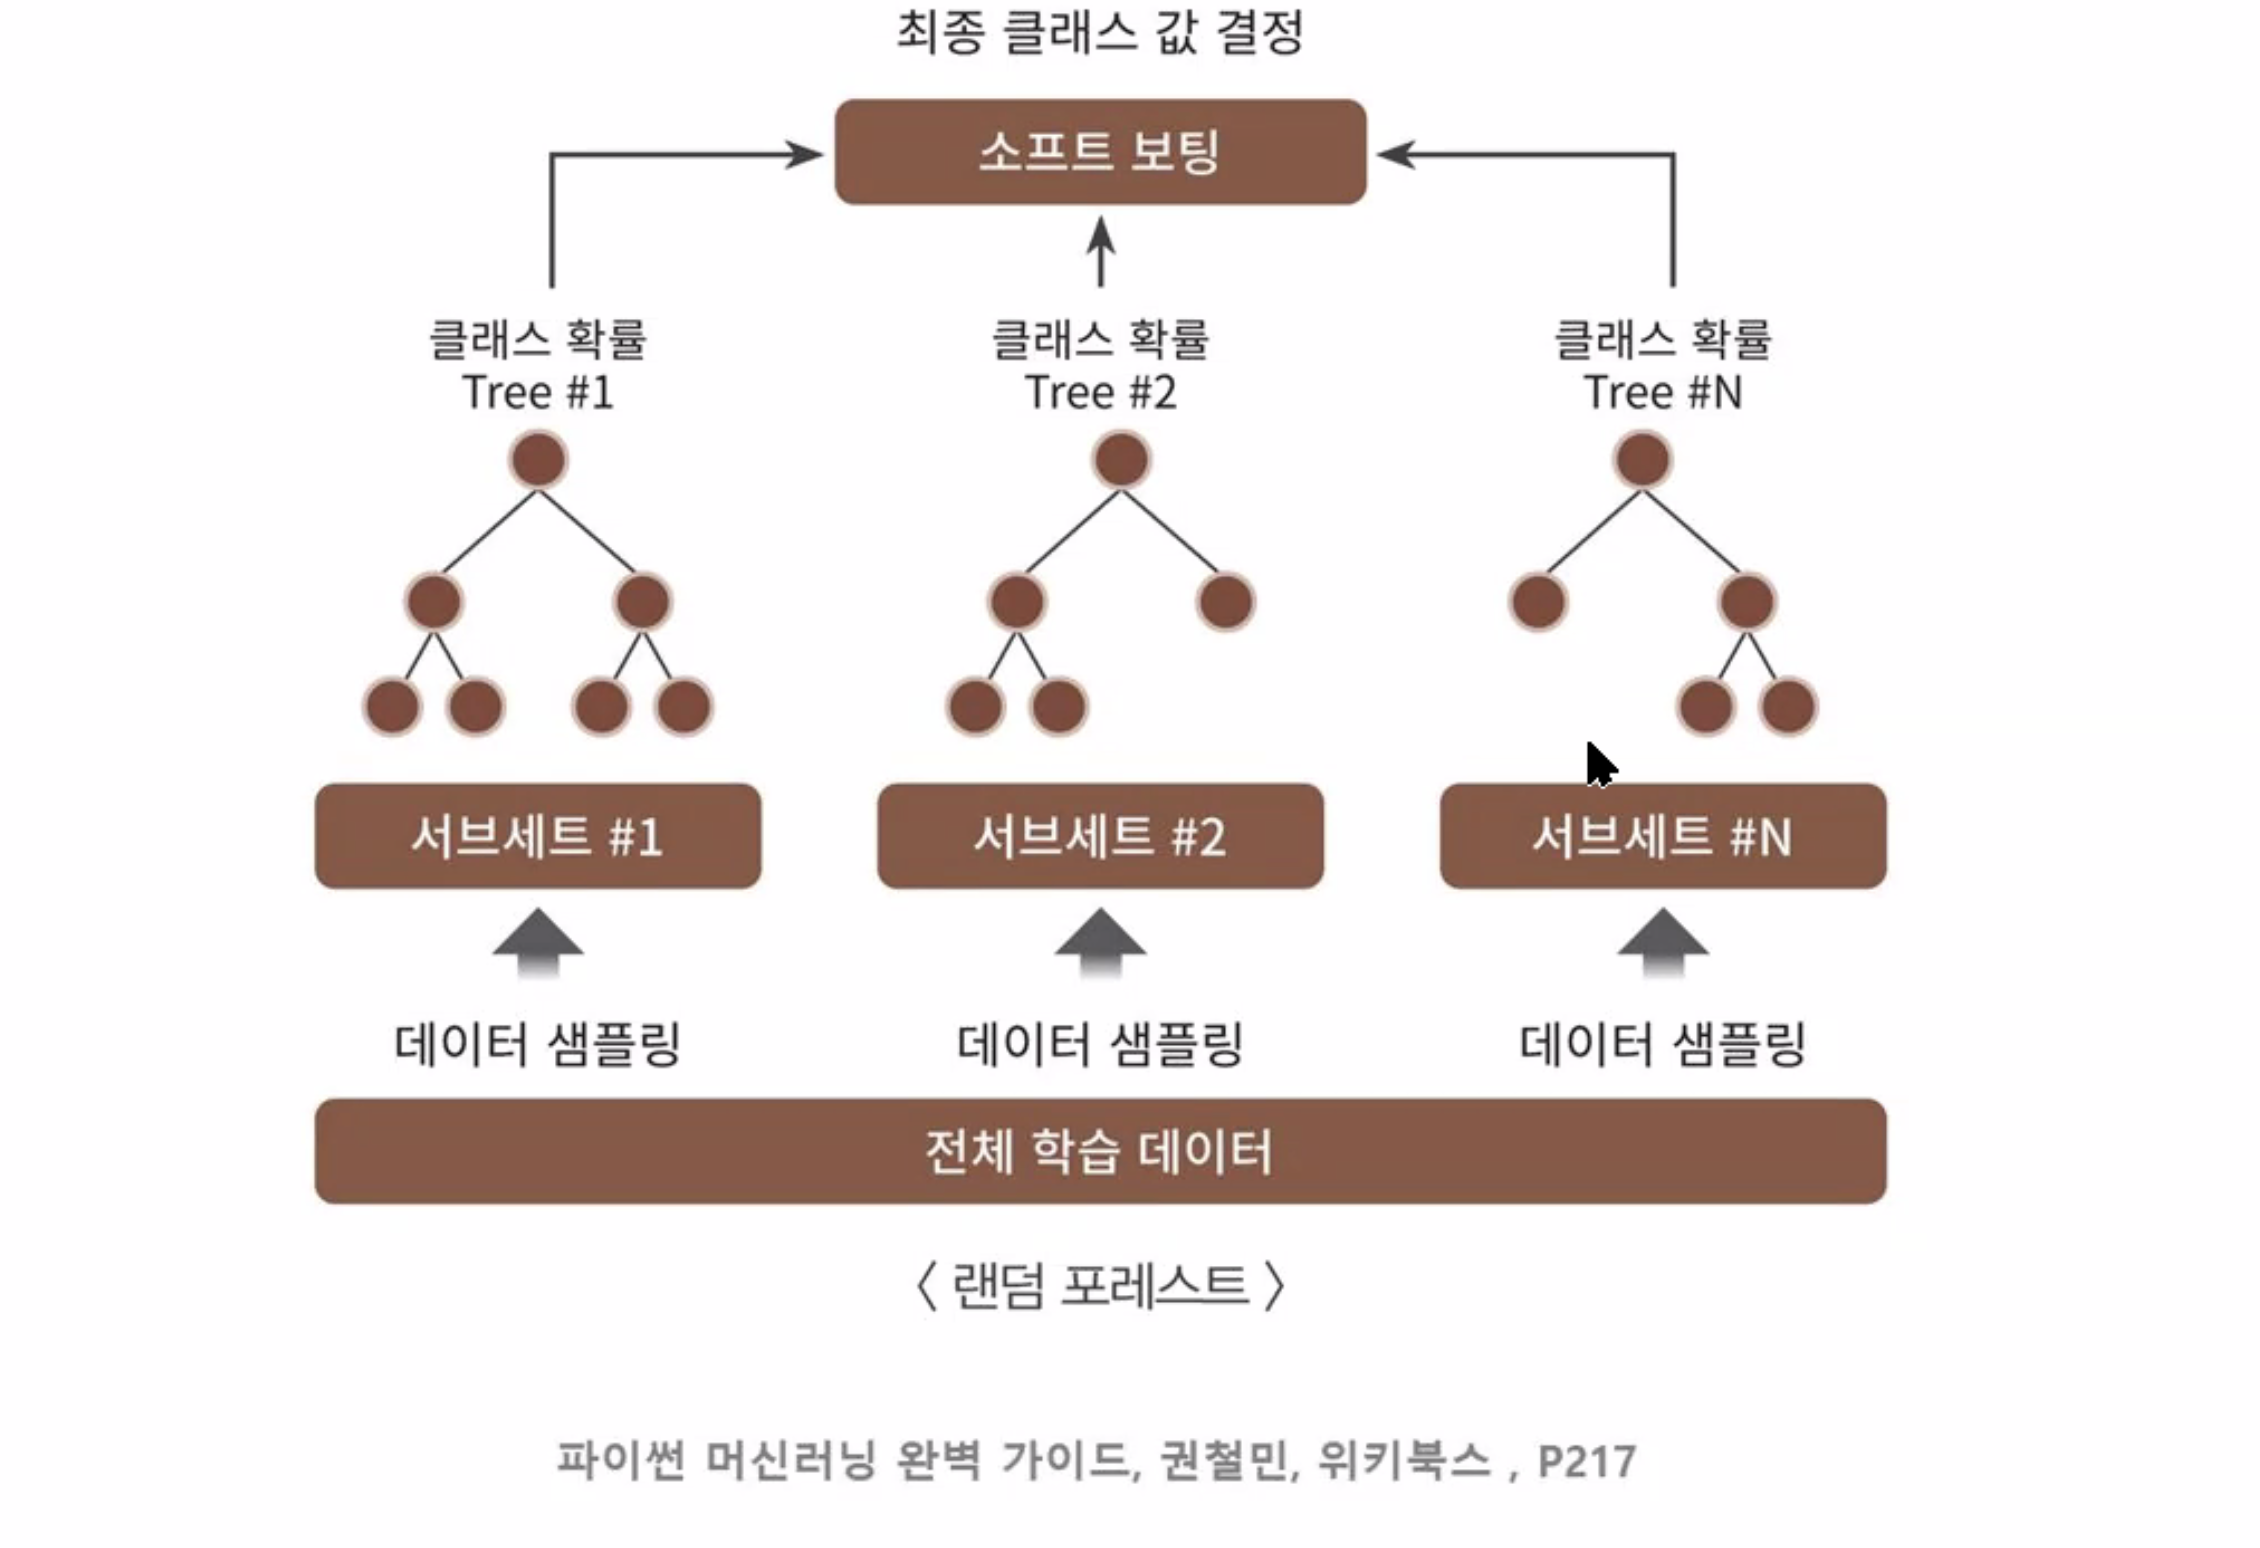

## 랜덤 포레스트에서의 부트 스트래핑 샘플링 방식

**부트스트래핑 분할 방식**  
개별 Classifier에게 데이터를 샘플링해서 추출하는 방식  
각 샘플링된 데이터 내에는 중복 데이터 포함  
  
**랜덤 포레스트에서의 부트 스트래핑 분할 방식**  
개별적인 분류기의 기반 알고리즘은 결정 트리지만 개별 트리가 학습하는 데이터 세트는  
전체 데이터에서 일부가 중복되게 샘플링된 데이터 세트  
Subset 데이터는 이러한 부트 스트래핑으로 데이터가 임의로 만들어짐  
Subset 데이터 건수는 전체 데이터 건수와 동일하지만 개별 데이터가 중복되어 있음  
  
예) 원본 데이터 건수가 10개인 학습 데이터 세트  
  랜덤 포레스트를 3개의 결정 트리 기반으로 학습하려고 n_estimators = 3 으로 하이퍼 파라미터를 부여하는 경우
    
**참고**  
Bagging : bootstrap aggragating 줄임말  
부트 스트랩 : 원래 통계학에서 여러 개의 작은 데이터 세트를 임의로 만들어 개별 평균의 분포도를 측정하는 목적을 위한 샘플링 방식  

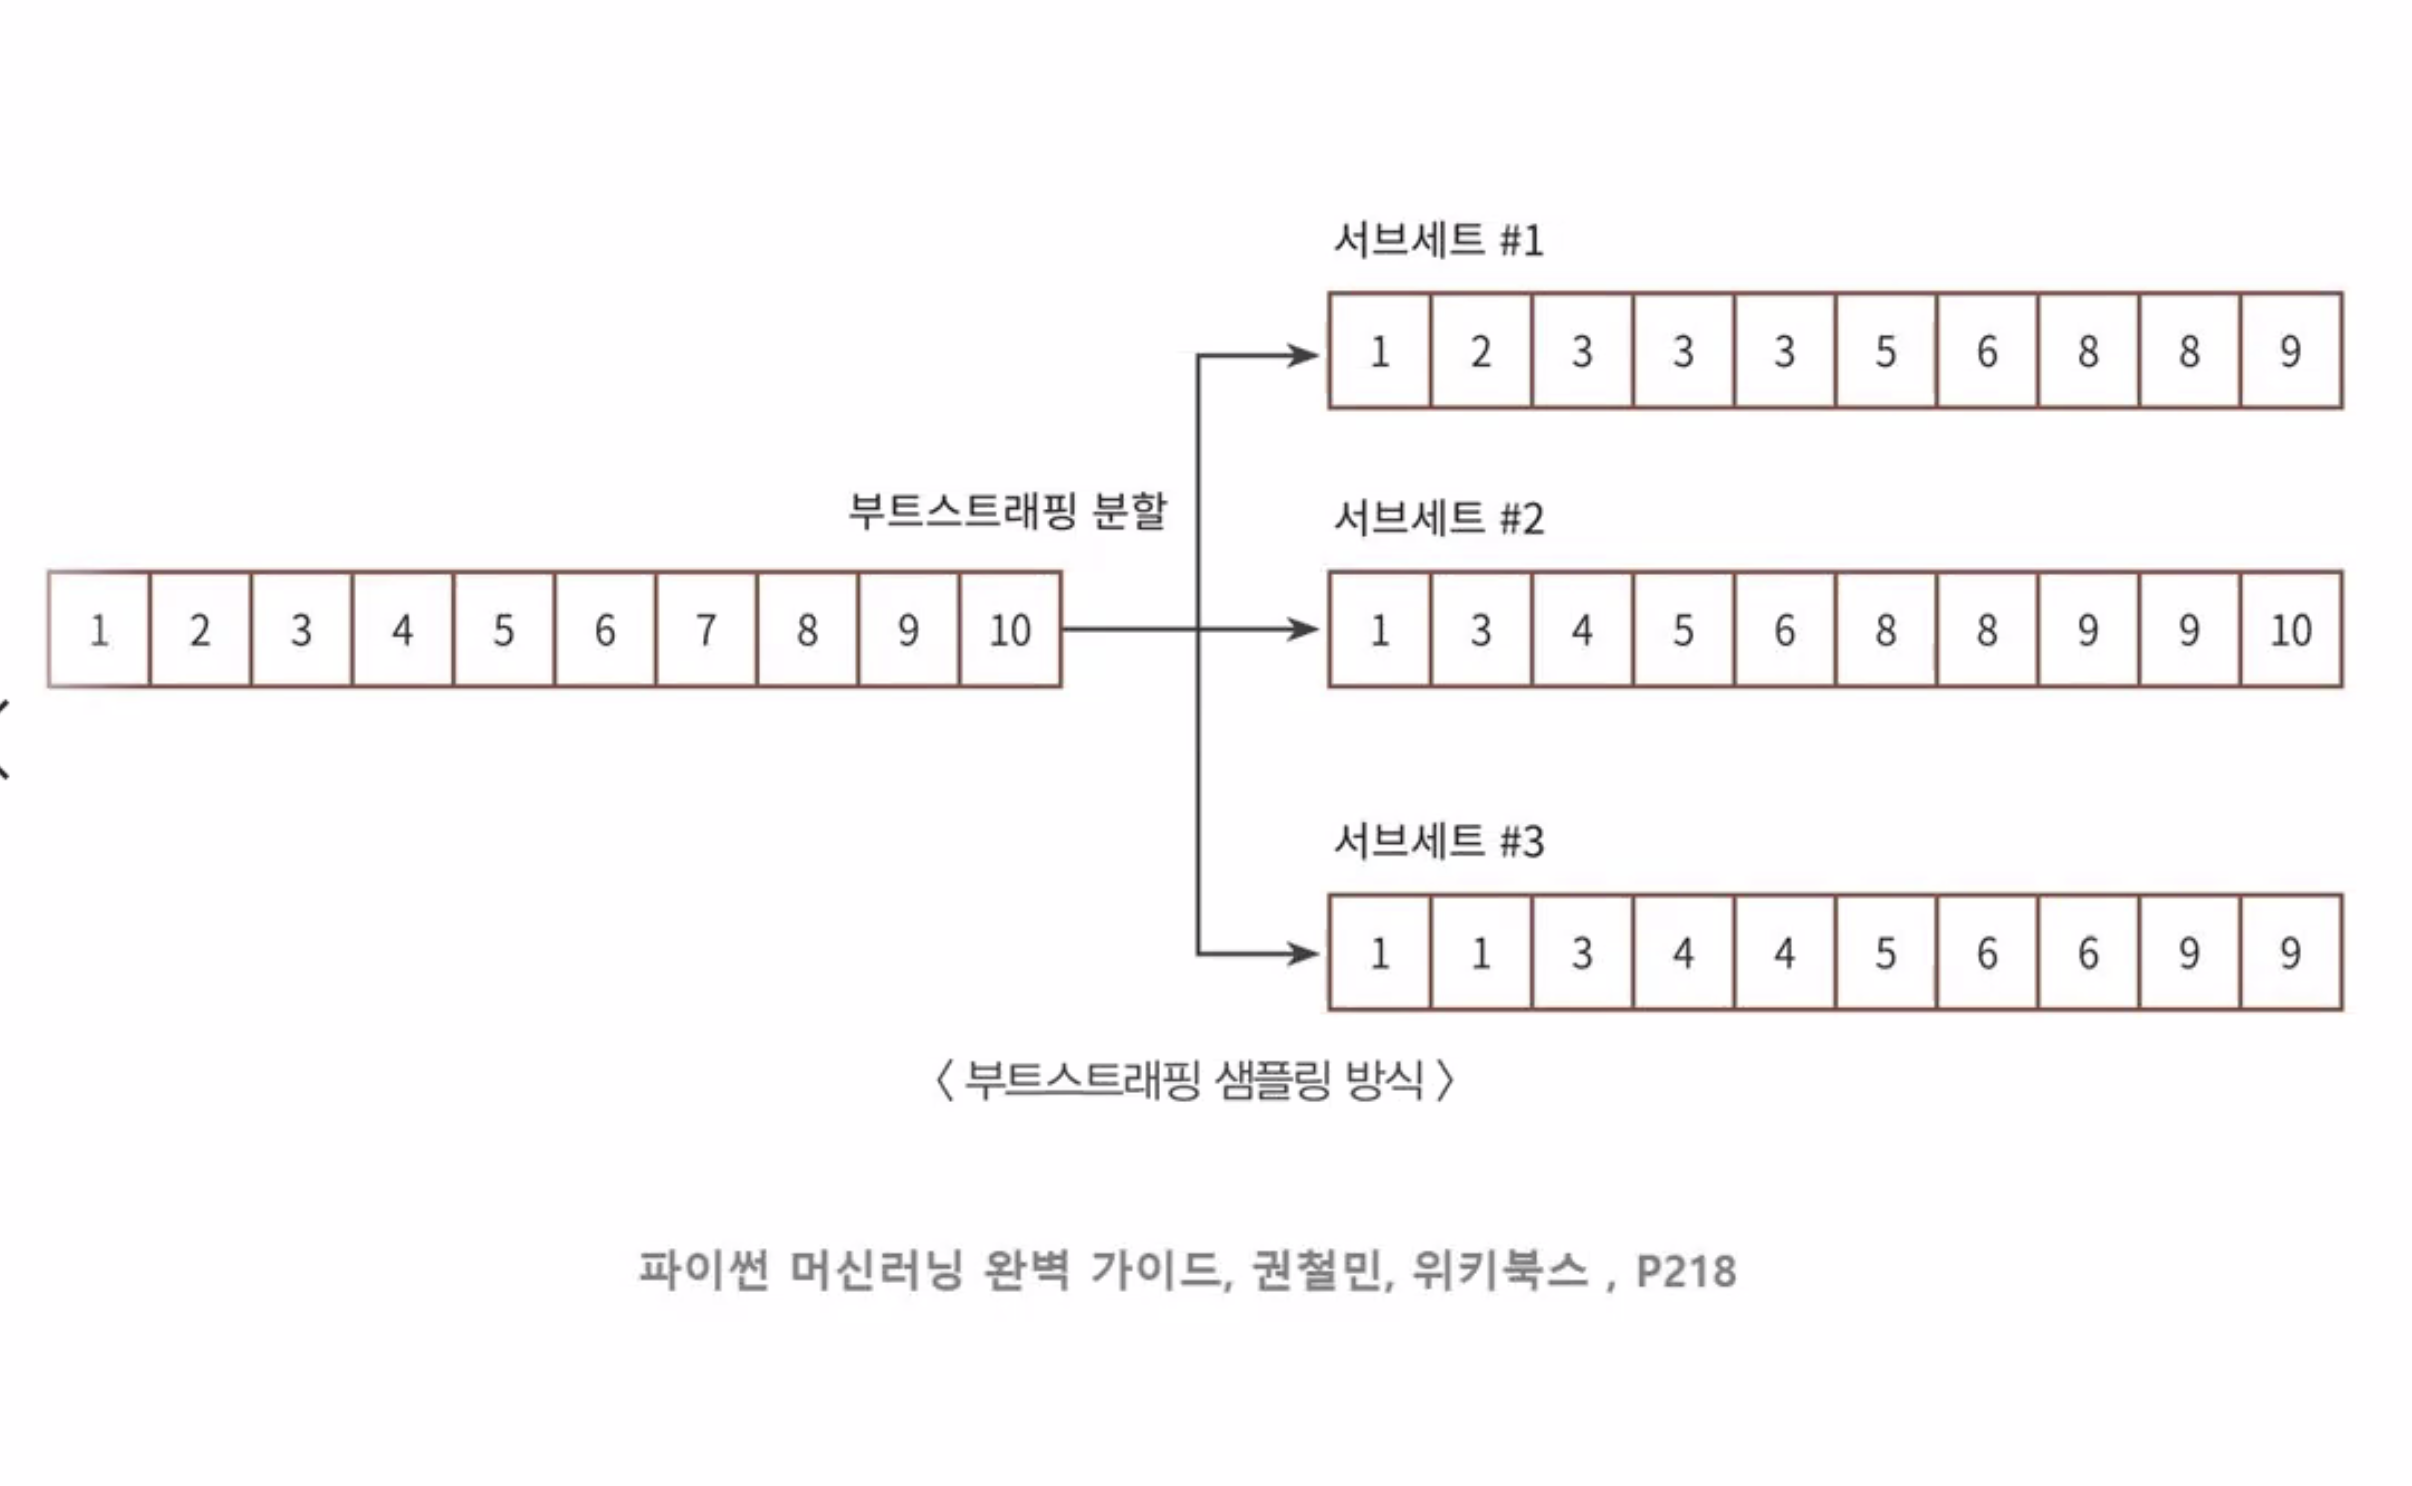

___
# 랜덤 포레스트 예제
앞의 사용자 인식 데이터 세트를 사이킷런의 RandomForestClassifier 클래스를 이용해 예측 수행  


In [5]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [11]:
# 피처명 변경해서 반환하는 과정을 함수로 작성
# 피처명_1 또는 피처명_2로 변경


def get_new_feature_name_df(old_feature_name_df):
    # gruopby('column_name').cumcount() : 중복되는 값이 몇 번째에 해당되는지 index로 반환
    # 0이면 첫 번째, 1이면 두 번째...
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    
    # merge() 하기 위해 index 값을 갖는 열 필요
    # reset_index() : index를 열로 변환
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [12]:
import pandas as pd

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('data/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('data/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('data/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('data/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [13]:
# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9253


___
# 랜덤 포레스트 하이퍼 파라미터
랜덤포레스트는 트리기반의 하이퍼 파라미터에 배깅, 부스팅, 학습, 정규화 등을 위한 하이퍼 파라미터까지 추가되므로 튜닝할 파라미터가 많습니다.
앞의 사용자 행동 데이터 세트 그대로 사용  
튜닝 시간을 절약하기 위해 n_setimators = 100, cv = 2  
  
예제 수행 시간 오래 걸림  
멀티 코어 환경에서는 빠르게 학습이 가능 그래서 그래디언트 부스팅보다 예측 성능이 약간 떨어지더라도  
랜덤 포레스트로 일단 기반 모델을 먼저 구출하는 경우가 많음  
멀티 코어 환경에서는 n_jobs=-1로 추가하면 모든 CPU 코어 이용해서 학습이 가능  
  
n_setimators : 결정 트리의 개수 (디폴트 10)
많이 설정할수록 성능을 기대할 수 있지만 계속 증가시킨다고 무조건 향상되는 것이 아님  
증가시킬수록 학습 수행 시간이 오래 걸린다는 문제가 있음  

In [15]:
# RandomForest의 하이퍼 파라미터 default 상태
model = RandomForestClassifier()
model

RandomForestClassifier()

#### GridSearchCV를 통한 랜덤포레스트의 하이퍼 파라미터 튜닝

In [17]:
from sklearn.model_selection import GridSearchCV

# 테스트 해 볼 데이터를 많이 넣으면 기하급수적으로 늘어남
params = { 'n_estimators' : [10, 100],  # 1차적으로 100으로 하고, 나중에 최적화되면 늘려서 최종 예측 수행
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]  # 4x3x3 : 36번
            }

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf = RandomForestClassifier(random_state = 0, n_jobs = -1)

# n_jobs = -1 전체 CPU 콜을 다 활용하라는 것임
# 개인 PC가 굉장히 많은 수행 성능을 차지하니까 느려짐 길게 걸릴 수 있음
# cv=2 너무 많게 설정하면 실행 시간이 오래 걸림 (총 72번 수행 : 36x2)
grid_cv = GridSearchCV(rf_clf, param_grid = params, cv = 2, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('최적 하이퍼 파라미터: ', grid_cv.best_params_)
print('최고 예측 정확도: {:.4f}'.format(grid_cv.best_score_))

## 결과
# 최적 하이퍼 파라미터: 'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
# 최고 예측 정확도: 0.9180

최적 하이퍼 파라미터:  {'max_depth': 10, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9180


In [18]:
# 튜닝된 하이퍼 파라미터로 재학습 및 예측 평가  
# GridSearchCV로 찾은 최적의 하이퍼 파라미터를 랜덤 포레스트에 적용해서 예측 수행

# n_estimators = 300으로 늘림
# 위 결과의 최적 하이퍼 파라미터를 다 입력해서 RandomForestClassifier 초기화 시키고 예측 성능 측정
rf_clf1 = RandomForestClassifier(n_estimators = 300, 
                                max_depth = 10,
                                min_samples_leaf = 8,
                                min_samples_split = 8,
                                random_state = 0,
                                n_jobs = -1)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {:.4f}'.format(accuracy_score(y_test,pred)))

예측 정확도: 0.9165


**결과**  
별도의 테스트 데이터 세트에서 수행한 예측 정확도 수치는 약 91.65% 입니다.  
RandomForestClassifier 역시 DecisionTrssClassifier 와 똑같이 feature_importances_ 속성을 이용해 알고리즘이 선택한  
피처의 중요도를 알 수 있습니다. 이 피처 중요도를 막대그래프로 알아보자  

___
# 피처 중요도 시각화
Random Forest의 각 피처의 중요도 시각화 : featureimportances

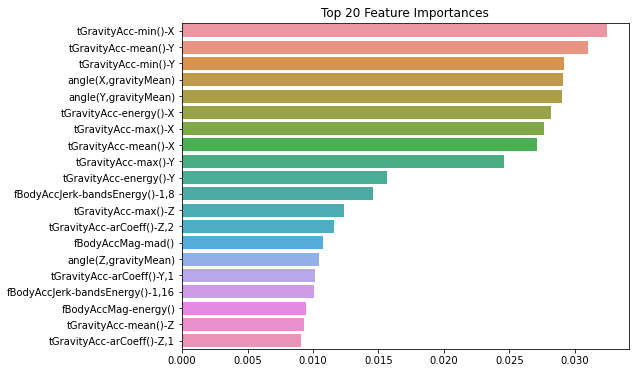

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
# sort_values() 쉽게 하기 위해서 시리즈로 만들고, 
# 최고 중요도가 높은 20개 피처들만 추출
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')

# x축은 중요도 값, y축은 ftr_top20 시리즈의 index
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()